In [3]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet import ResNet50
import cv2
from keras.preprocessing import image
import numpy as np
import pandas as pd 
from keras.applications.resnet import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from keras.layers import GlobalMaxPooling2D
import warnings
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet121
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os


In [3]:
path = "C:/Users/ligra/Desktop/диплом/fashion-dataset/images/"

In [4]:
#prerparing dataset
def preparing_dataset():
    df = pd.read_csv('C:/Users/ligra/Desktop/диплом/fashion-dataset/styles.csv', error_bad_lines=False)
    #looking for classes where the number of images is < 8, so that each class falls into each of the samples
    del_index = df.articleType.value_counts().reset_index().rename(columns={'index':'articleType', 'articleType':'count'})
    del_index =del_index[del_index['count'] < 9]

    flags_buf  = df.articleType.reset_index()
    del_indexes = []

    for i in del_index.articleType:
        array_buf = flags_buf[flags_buf['articleType'] == i]
        del_indexes = array_buf['index']
        df = df.drop(del_indexes)
    
    #removing missing images from dataset
    missing_img = []
    for idx, line in df.iterrows():
        if not os.path.exists(os.path.join('C:/Users/ligra/Desktop/диплом/fashion-dataset/', 'images', str(line.id)+'.jpg')):
            missing_img.append(idx)
        
    df.drop(df.index[missing_img], inplace=True)
    del_indexes = [6695, 16194, 32309, 36381]
    df = df.drop(del_indexes)
    return df

In [10]:
#functions for saving and loading features datasets
def save_in_pickle(data, pickle_file):
    file = open(pickle_file,"wb")
    pickle.dump(data,file)
    file.close()

def load_from_pickle(pickle_file):
    file = open(pickle_file,'rb')
    pickle_data = pickle.load(file)
    file.close()
    return pickle_data

def load_train_features(model):
    train_df = load_from_pickle(model+ "_train")
    return train_df[0], train_df[1], train_df[2]

def load_test_features(model):
    test_df = load_from_pickle(model+ "_test")
    return test_df[0], test_df[1], test_df[2]

In [6]:
#functions for creating models
def mobilenet(h, w):
    model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (h, w, 3))
    model_mobilenet.trainable = False
    mobilenet_output = GlobalMaxPooling2D()(model_mobilenet.outputs)
    model_mobilenet = Model(inputs=model_mobilenet.inputs, outputs=mobilenet_output)
    model_mobilenet.summary()
    return model_mobilenet

def resnet(h, w):
    model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape = (h, w, 3))
    model_resnet.trainable = False
    resnet_output = GlobalMaxPooling2D()(model_resnet.outputs)
    model_resnet = Model(inputs=model_resnet.inputs, outputs=resnet_output)
    model_resnet.summary()
    return model_resnet

def vgg(h, w):
    model_vgg = VGG16(weights='imagenet', include_top=False, input_shape = (h, w, 3))
    model_vgg.trainable = False
    vgg_output = GlobalMaxPooling2D()(model_vgg.outputs)
    model_vgg = Model(inputs=model_vgg.inputs, outputs=vgg_output)
    model_vgg.summary()
    return model_vgg

def densenet(h, w):
    model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape = (h, w, 3))
    model_densenet.trainable = False
    densenet_output = GlobalMaxPooling2D()(model_densenet.outputs)
    model_densenet = Model(inputs=model_densenet.inputs, outputs=densenet_output)
    model_densenet.summary()
    return model_densenet


In [13]:
def get_feature_vector(model, image):
    feature_v = model.predict(image)
    feature_v = feature_v.flatten()
    return feature_v

def gen_features(model, df):
    features = []
    labels = []
    id_array = []
    path = "C:/Users/ligra/Desktop/диплом/fashion-dataset/images/"
    count=0
    for index, row in df.iterrows():
        imageId = row.id
        id_array.append(imageId)
        label = row.articleType
        img = plt.imread(path + str(imageId)+".jpg")
        img = cv2.resize(img, (224, 224)) 
        img =  np.expand_dims(img, axis = 0) 
        feature_v = get_feature_vector(model, img)
        features.append(feature_v)
        labels.append(label)
        count+=1
    return np.array(features), labels, id_array

def gen_several_features(train_features_1, test_features_1, train_features_2, test_features_2, weight_1, weight_2):
    len_v_1 = train_features_1.shape[1]
    len_v_2 = train_features_2.shape[1]
    print(len_v_1, len_v_2)
    class_encoder = preprocessing.LabelEncoder()
    class_encoder.fit(train_labels)
    labels = class_encoder.transform(train_labels)
    if(len_v_1 > len_v_2):
        new = SelectKBest(k=len_v_2).fit(train_features_1, labels)
        train_features_1 = new.transform(train_features_1)
        test_features_1 = new.transform(test_features_1)
    else:
        new = SelectKBest(k=len_v_1).fit(train_features_2, labels)
        train_features_2 = new.transform(train_features_2)
        test_features_2 = new.transform(test_features_2)

    comb_train_features = train_features_1 * weight_1 + train_features_2 * weight_2
    comb_test_features = test_features_1 * weight_1 + test_features_2 * weight_2
    return comb_train_features, comb_test_features

In [8]:
def predict(train_index, train_labels):
    result = {}
    for index in train_index:
        class_id  = train_labels[index]
        if(class_id not in result):
            result[class_id] = 0
        result[class_id]+=1
    return max(result, key=result.get) 

In [60]:
def show_rec(trainIndex, train_id):
    id_array = []
    for index in trainIndex:
        path = "C:/Users/ligra/Desktop/диплом/fashion-dataset/images/"
        id_array.append(train_id[index])
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        image = plt.imread(path + str(int(id_array[i])) + ".jpg")
        plt.imshow(image, cmap=plt.cm.jet)
        
def KNN_faster(train_features, train_labels, k, test_features, test_labels, train_id):
    true_labels = []
    predicted_labels = [] 
    a = np.linalg.norm(test_features, axis = 1, ord=2)
    b = np.linalg.norm(train_features, axis = 1, ord=2)
    a = a.reshape(len(test_features),1)
    b = b.reshape(1,len(train_features))
    c = np.matmul(a, b)
    d =  np.dot(test_features, train_features.T)/c
    
    path = "C:/Users/ligra/Desktop/диплом/fashion-dataset/images/"
    
    for i in range(1,2000):
        #img = plt.imread(path + str(int(train_id[i])) + ".jpg")
        #plt.figure()
        #plt.imshow(img)
        
        test_label = test_labels[i]
        true_labels.append(test_label)
        train_dist =  d[i]
        train_index = train_dist.argsort()[-k:]
        #show_rec(train_index, train_id)
        result = predict(train_index, train_labels)
        predicted_labels.append(result)    
    
    return true_labels, predicted_labels

In [10]:
#calculate metrics
def calculatePR(true_labels, predicted_labels): 
    acc = 0
    tp = 0
    precision_arr = []
    recall_arr = []
    for i in range(len(true_labels)):
        if (true_labels[i] == predicted_labels[i]):
            acc+=1
            tp+=1
        precision =  tp/(i+1)
        precision_arr.append(precision)
        recall =  tp/len(predicted_labels)
        recall_arr.append(recall)
    print(acc/len(true_labels))
    return precision_arr, recall_arr

In [11]:
df = preparing_dataset()

C:\Users\ligra\AppData\Local\Temp/ipykernel_5740/1915671012.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  df = preparing_dataset()
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748

In [ ]:
tags_train, tags_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df['articleType'])

In [ ]:
#creating network models
model = resnet(224, 224)
train_features, train_labels , train_ids = gen_features(model, tags_train)
test_features, test_labels, test_ids = gen_features(model, tags_test)
save_in_pickle([train_features, train_labels , train_ids], "resnet_train")
save_in_pickle([test_features, test_labels, test_ids], "resnet_test")

model = mobilenet(224, 224)
train_features, train_labels , train_ids = gen_features(model, tags_train)
test_features, test_labels, test_ids = gen_features(model, tags_test)
save_in_pickle([train_features, train_labels , train_ids], "mobilenet_train")
save_in_pickle([test_features, test_labels, test_ids], "mobilenet_test")

model = vgg(224, 224)
train_features, train_labels , train_ids = gen_features(model, tags_train)
test_features, test_labels, test_ids = gen_features(model, tags_test)
save_in_pickle([train_features, train_labels , train_ids], "vgg_train")
save_in_pickle([test_features, test_labels, test_ids], "vgg_test")

model = densenet(224, 224)
train_features, train_labels , train_ids = gen_features(model, tags_train)
test_features, test_labels, test_ids = gen_features(model, tags_test)
save_in_pickle([train_features, train_labels , train_ids], "densenet_train")
save_in_pickle([test_features, test_labels, test_ids], "densenet_test")


In [34]:
train_features, train_labels , train_ids = load_train_features("vgg")
test_features, test_labels , test_ids = load_test_features("vgg")

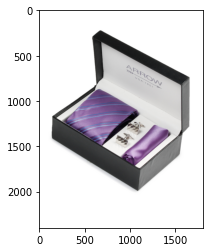

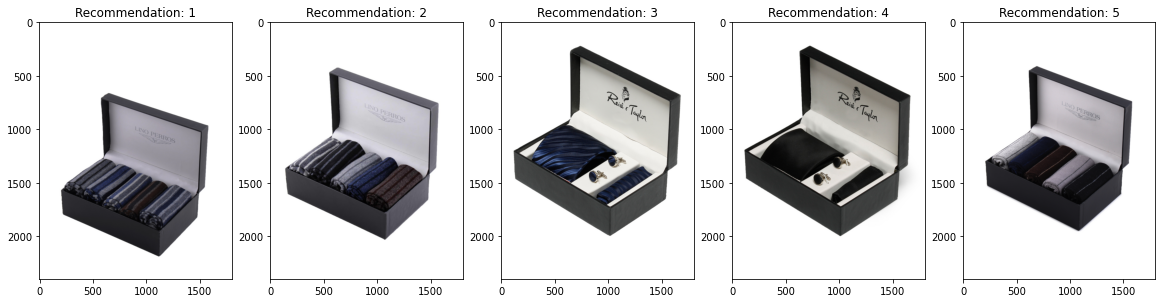

In [37]:
#example work
true_labels, predicted_labels = KNN_faster(train_features, train_labels, 5, test_features, test_labels, train_ids)

In [96]:
def compare_models():
    models_names = ['vgg', 'resnet', 'mobilenet',  'densenet'] 
    plt.figure(figsize=(10, 5))
    i = 0
    for model in models_names:    
        train_features, train_labels , train_ids = load_train_features(model)
        test_features, test_labels , test_ids = load_test_features(model)
        correct_labels, predicted_labels = KNN_faster(train_features, train_labels, 3, test_features, test_labels, train_ids)
        precision_arr , recall_arr = calculatePR(correct_labels, predicted_labels)
        print(models_names[i], "precision avg = ", np.mean(precision_arr), "recall avg = ", np.mean(recall_arr))
        plt.plot(recall_arr, precision_arr, label= models_names[i])
        i+=1
    #base_rec_system
    #recall_arr, precision_arr = load_from_pickle('base_rec_system')
    #plt.plot(recall_arr, precision_arr, label="Базовая рек. система", c='r')
    
    plt.title("Зависимость точности работы рек. системы от полноты")
    plt.xlabel('Полнота (recall)', fontsize=12)
    plt.ylabel('Точность работы (precision)', fontsize=12)

    plt.grid()
    plt.legend()
    plt.show()

0.7748123436196831
vgg precision avg =  0.7783200455590996 recall avg =  0.36268508109418696


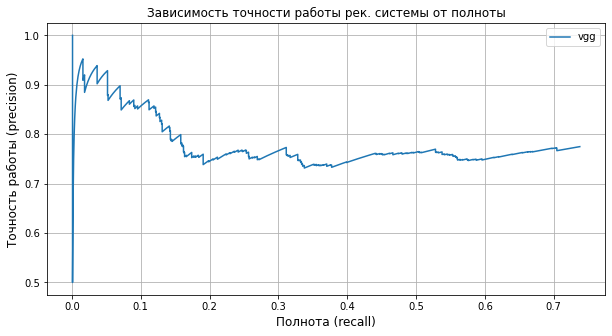

In [97]:
#vgg
#models_names = ['vgg'] 
compare_models()

0.7389491242702252
resnet precision avg =  0.7339803400714128 recall avg =  0.3409731832391435


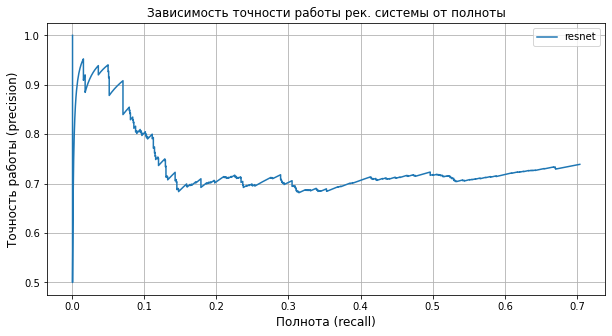

In [90]:
#resnet
#models_names = ['resnet'] 
compare_models()

0.7164303586321935
mobilenet precision avg =  0.7301179601320532 recall avg =  0.33855655460832135


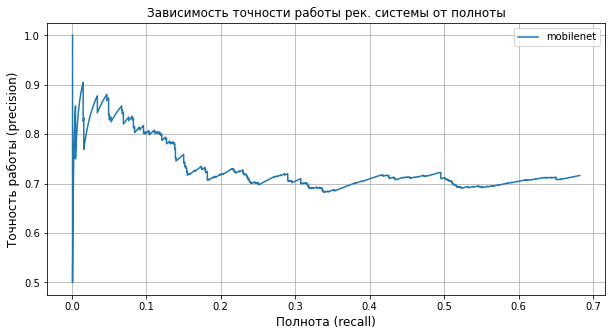

In [92]:
#mobilenet
#models_names = ['mobilenet'] 
compare_models()

0.6288573811509591
densenet precision avg =  0.6323293960623178 recall avg =  0.29292082825176663


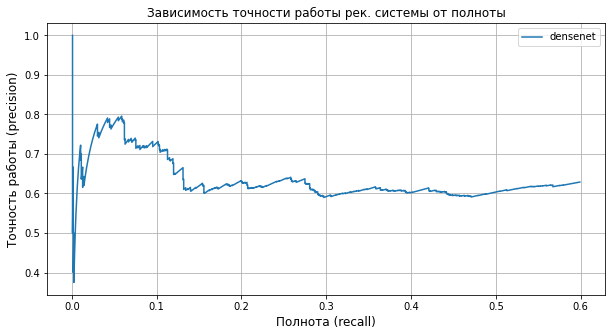

In [94]:
#densenet
#models_names = ['densenet'] 
compare_models()

0.7748123436196831
vgg precision avg =  0.7783200455590996 recall avg =  0.36268508109418696
0.7389491242702252
resnet precision avg =  0.7339803400714128 recall avg =  0.3409731832391435
0.7164303586321935
mobilenet precision avg =  0.7301179601320532 recall avg =  0.33855655460832135
0.6288573811509591
densenet precision avg =  0.6323293960623178 recall avg =  0.29292082825176663


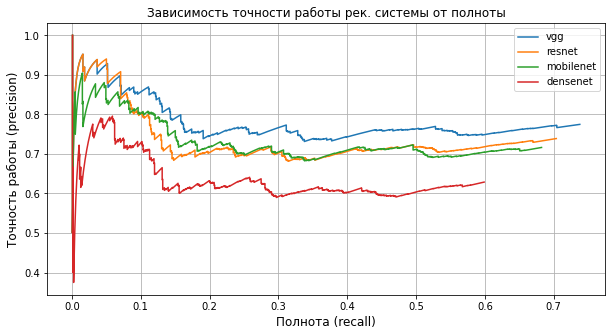

In [78]:
#all network models
compare_models()

0.7748123436196831
vgg precision avg =  0.7783200455590996 recall avg =  0.36268508109418696
0.7389491242702252
resnet precision avg =  0.7339803400714128 recall avg =  0.3409731832391435
0.7164303586321935
mobilenet precision avg =  0.7301179601320532 recall avg =  0.33855655460832135
0.6288573811509591
densenet precision avg =  0.6323293960623178 recall avg =  0.29292082825176663


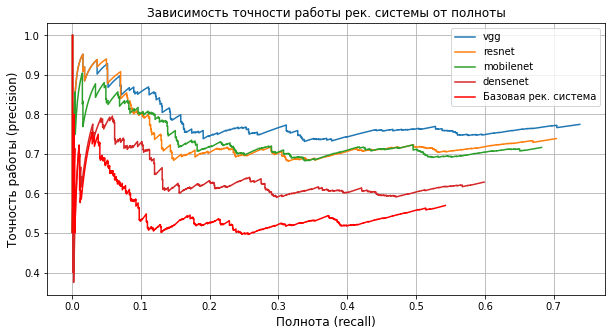

In [80]:
#all network models with base model
compare_models()

0.7748123436196831
vgg precision avg =  0.7783200455590996 recall avg =  0.36268508109418696
0.7389491242702252
resnet precision avg =  0.7339803400714128 recall avg =  0.3409731832391435


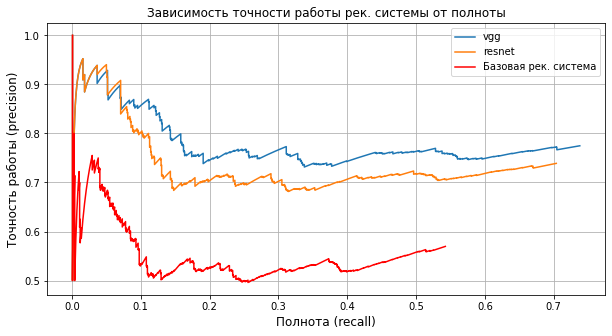

In [83]:
#better network models with base model
compare_models()

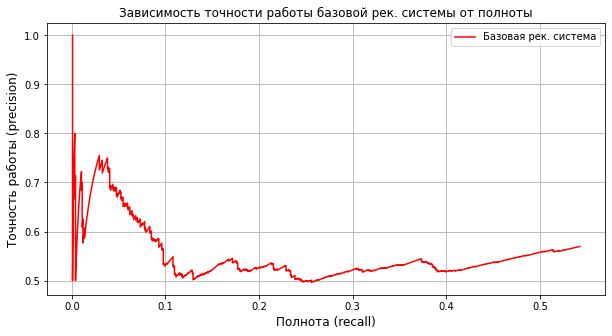

In [81]:
#base rec system
recall_arr, precision_arr = load_from_pickle('base_rec_system')

plt.figure(figsize=(10, 5))
plt.plot(recall_arr, precision_arr, label="Базовая рек. система", c='r')
plt.title("Зависимость точности работы базовой рек. системы от полноты")
plt.xlabel('Полнота (recall)', fontsize=12)
plt.ylabel('Точность работы (precision)', fontsize=12)
plt.grid()
plt.legend()
plt.show()